<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Identificardor_de_Parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

63358.41854086953


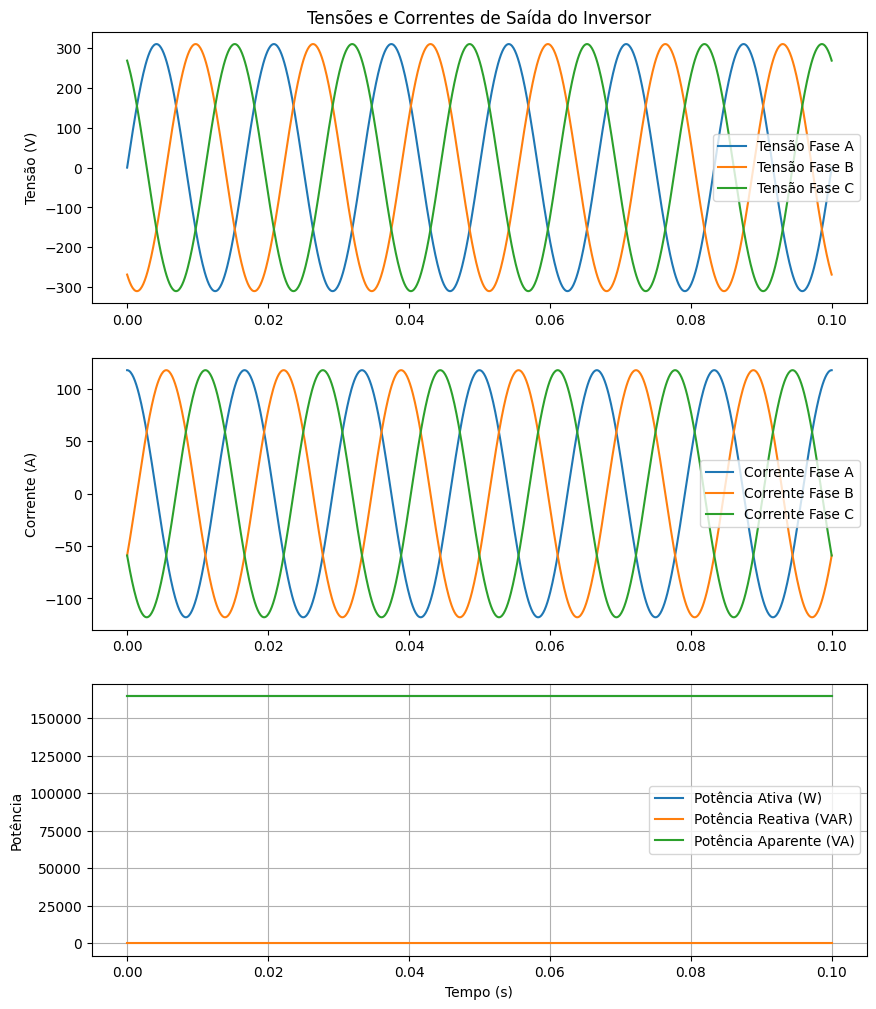

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class InversorWEGCFW300:
    def __init__(self, V_m, f, V_dc, i_dc, phi, theta, f_s, m):
        self.V_m = V_m  # Tensão de entrada RMS (V)
        self.f = f  # Frequência de entrada (Hz)
        self.V_dc = V_dc  # Tensão CC (V)
        self.i_dc = i_dc  # Corrente CC (A)
        self.phi = phi  # Ângulo de fase da tensão de entrada (rad)
        self.theta = theta  # Ângulo de fase da corrente de saída (rad)
        self.f_s = f_s  # Frequência de chaveamento (Hz)
        self.m = m  # Índice de modulação

        # Cálculo do período de chaveamento
        self.T_s = 1 / f_s

        # Cálculo do ângulo de modulação
        self.theta_m = np.arcsin(m)

        # Cálculo da frequência angular de entrada
        self.omega = 2 * np.pi * f

        # Cálculo da tensão de saída fundamental
        self.V_o1 = (2 * V_dc / np.pi) * m

    def gerar_tensoes_saida(self, t):
        u_a = self._gerar_funcao_comutacao(t, self.theta_m)
        u_b = self._gerar_funcao_comutacao(t, self.theta_m + 2 * np.pi / 3)
        u_c = self._gerar_funcao_comutacao(t, self.theta_m + 4 * np.pi / 3)

        v_sw_a = self.V_dc * u_a
        v_sw_b = self.V_dc * u_b
        v_sw_c = self.V_dc * u_c

        v_a = v_sw_a * np.sin(self.omega * t - self.phi)
        v_b = v_sw_b * np.sin(self.omega * t - self.phi - 2 * np.pi / 3)
        v_c = v_sw_c * np.sin(self.omega * t - self.phi + 2 * np.pi / 3)

        return v_a, v_b, v_c

    def gerar_correntes_saida(self, t):
        # Utilizando a mesma forma das tensões, por simplicidade
        i_a, i_b, i_c = self.gerar_tensoes_saida(t)
        i_a = self.i_dc * np.sin(self.omega * t - self.theta + np.pi/2)
        i_b = self.i_dc * np.sin(self.omega * t - self.theta - 2 * np.pi / 3 + np.pi/2)
        i_c = self.i_dc * np.sin(self.omega * t - self.theta + 2 * np.pi / 3 + np.pi/2)
        return i_a, i_b, i_c

    def calcular_potencias(self, v_a, v_b, v_c, i_a, i_b, i_c):
        V_ef = np.sqrt(np.mean(v_a**2 + v_b**2 + v_c**2))
        I_ef = np.sqrt(np.mean(i_a**2 + i_b**2 + i_c**2))
        P = 3 * V_ef * I_ef * np.cos(0)
        Q = np.mean(v_a * i_a * np.sin(self.phi)) + np.mean(v_b * i_b * np.sin(self.phi)) + np.mean(v_c * i_c * np.sin(self.phi))
        S = np.sqrt(P**2 + Q**2)
        return P, Q, S

    def _gerar_funcao_comutacao(self, t, theta_m):
        k = np.floor((t + self.T_s / 4) / self.T_s)
        u = (t < (k * self.T_s + theta_m)).astype(int)
        return u

# Parâmetros do inversor
V_m = 220
f = 60
V_dc = 310
i_dc = 118
phi = 0
theta = 0
f_s = 100
m = 0.01

t_sim = 0.1
t = np.linspace(0, t_sim, 1000)

inversor = InversorWEGCFW300(V_m, f, V_dc, i_dc, phi, theta, f_s, m)

v_a, v_b, v_c = inversor.gerar_tensoes_saida(t)
i_a, i_b, i_c = inversor.gerar_correntes_saida(t)
Pin= np.sqrt(3) * V_dc * i_dc * np.cos(0)
print(Pin)
Pa, Q, S = inversor.calcular_potencias(v_a, v_b, v_c, i_a, i_b, i_c)

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(t, v_a, label='Tensão Fase A')
plt.plot(t, v_b, label='Tensão Fase B')
plt.plot(t, v_c, label='Tensão Fase C')
plt.title('Tensões e Correntes de Saída do Inversor')
plt.ylabel('Tensão (V)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, i_a, label='Corrente Fase A')
plt.plot(t, i_b, label='Corrente Fase B')
plt.plot(t, i_c, label='Corrente Fase C')
plt.ylabel('Corrente (A)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.full_like(t, Pa), label='Potência Ativa (W)')
plt.plot(t, np.full_like(t, Q), label='Potência Reativa (VAR)')
plt.plot(t, np.full_like(t, S), label='Potência Aparente (VA)')
plt.xlabel('Tempo (s)')
plt.ylabel('Potência')
plt.legend()

plt.grid(True)
plt.show()


### Documentação Simulação Motor de Gaiola

Fundamentação teorica:

* 1 Principios de Converção Eletromecânica (3º Captulo)
* 2 Motor de Indução Trifasico (6º Captulo)
** 2.1 Analise de Cricuito Equivalente
** 2.2 Torque
** 2.3 Escorregamento
* 3 Conceitos de circuitos trifasicos (Apendice A)

Escorregamento máximo e torque: s=0.10400000000000001, Torque=115.82752593438246 Nm
Velocidade Sincrona: 188.49555921538757 (rad/s) ou 1800.0RPM


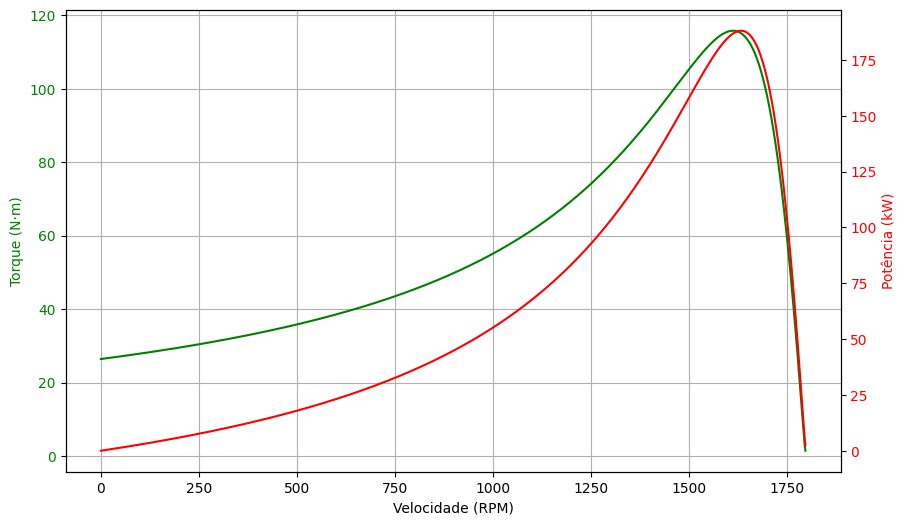

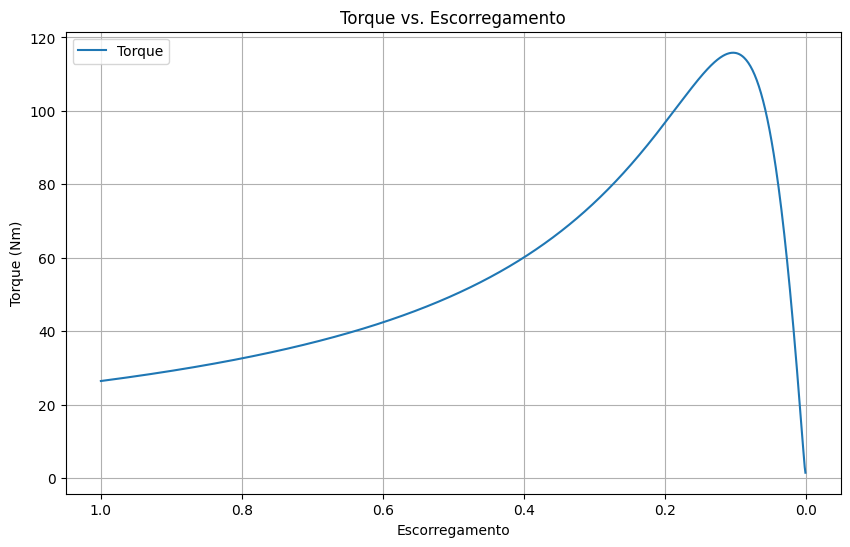

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_armadura(self, V_fase,s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_torque(self, V_fase, s):

        # Tensão induzida no rotor
        E2 = self.calcular_tensao_induzida(V_fase, s)

        # Corrente do rotor
        I2 = self.calcular_corrente_de_armadura(V_fase, s)
        # Potência no rotor e torque
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / self.w_s

        return self.K * torque  # Aplica a constante de proporcionalidade

    def encontrar_maior_torque(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        max_torque = max(torques)
        max_s = escorregamentos[torques.index(max_torque)]
        return max_s, max_torque

    def calcular_velocidade_angular(self, escorregamentos):
        return (self.w_s * (1 - escorregamentos)) * (30 / np.pi)

    def simular_desempenho(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        plt.figure(figsize=(10, 5))
        plt.plot(escorregamentos, torques, label='Torque (Nm)')
        plt.title('Torque vs. Escorregamento')
        plt.xlabel('Escorregamento')
        plt.ylabel('Torque (Nm)')
        plt.grid(True)
        plt.show()

# Exemplo de uso
frequencia = 60  # frequência em Hz
P = 4  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 0.95  # Constante de proporcionalidade para o torque ajustada para exemplo

# Instanciação do motor
motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Tensão aplicada (exemplo)
V_fase = V_m / np.sqrt(3)  # Tensão de fase (V) a partir de uma tensão de linha de 220V


# Simular o desempenho do motor para uma faixa de escorregamentos
escorregamentos = np.linspace(0.001, 1, 1000)
torques = [motor.calcular_torque(V_fase, s) for s in escorregamentos]
Pmec = [(motor.calcular_torque(V_fase, s) * motor.calcular_velocidade_angular(s))/1000 for s in escorregamentos]
# Encontrar maior torque
s_max, torque_max = motor.encontrar_maior_torque(V_fase, escorregamentos)

print(f"Escorregamento máximo e torque: s={s_max}, Torque={torque_max} Nm")
print(f"Velocidade Sincrona: {motor.w_s} (rad/s) ou {(motor.w_s)*30/np.pi}RPM")

# Calcular a velocidade percentual
velocidades_percentuais = (1 - escorregamentos) * ((motor.w_s)*30/np.pi)

esp=np.abs(-escorregamentos)

# Plotagem de Torque vs. Velocidade Percentual
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotar torque no primeiro eixo (esquerdo)
ax1.plot(velocidades_percentuais, torques, 'g-', label='Torque')
ax1.set_xlabel('Velocidade (RPM)')
ax1.set_ylabel('Torque (N·m)', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Criar um segundo eixo y para a potência (direito)
ax2 = ax1.twinx()
ax2.plot(velocidades_percentuais, Pmec, 'r-', label='Potência Mecânica')
ax2.set_ylabel('Potência (kW)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Ajustar a exibição dos grids
ax1.grid(True)

# Mostrar o gráfico
plt.show()
'''
print('\n')

# Calcular e plotar a velocidade angular mecânica vs. escorregamento
velocidades_angulares = motor.calcular_velocidade_angular(escorregamentos)

plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, velocidades_angulares)
plt.title('Velocidade Angular Mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Velocidade Angular Mecânica (RPM)')
plt.grid(True)
plt.show()
'''
print('\n')

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, torques, label='Torque')
plt.title('Torque vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


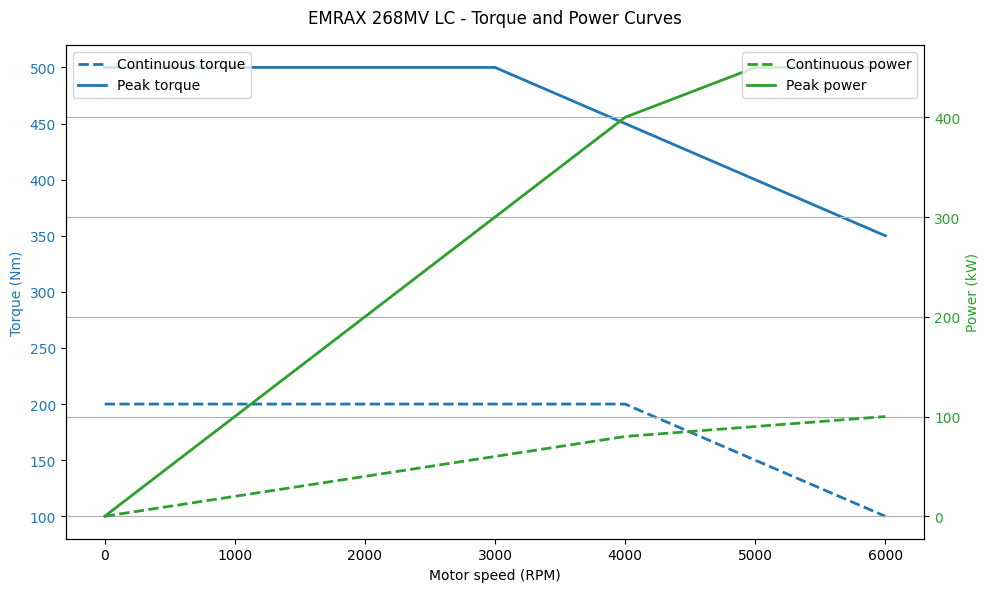

In [3]:
# @title Estimação de curva EMRAX268
import numpy as np
import matplotlib.pyplot as plt

# Dados de RPM e Torque/Potência
rpm = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000])
torque_continuo = np.array([200, 200, 200, 200, 200, 150, 100])
torque_pico = np.array([500, 500, 500, 500, 450, 400, 350])
potencia_continua = np.array([0, 20, 40, 60, 80, 90, 100])
potencia_pico = np.array([0, 100, 200, 300, 400, 450, 450])

# Plotando as curvas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curva de Torque (em Nm)
ax1.set_xlabel('Motor speed (RPM)')
ax1.set_ylabel('Torque (Nm)', color='tab:blue')
ax1.plot(rpm, torque_continuo, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax1.plot(rpm, torque_pico, label='Peak torque', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Segundo eixo Y para Potência (em kW)
ax2 = ax1.twinx()
ax2.set_ylabel('Power (kW)', color='tab:green')
ax2.plot(rpm, potencia_continua, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(rpm, potencia_pico, label='Peak power', color='tab:green', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adicionando título e legendas
fig.suptitle('EMRAX 268MV LC - Torque and Power Curves')
fig.tight_layout()

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()


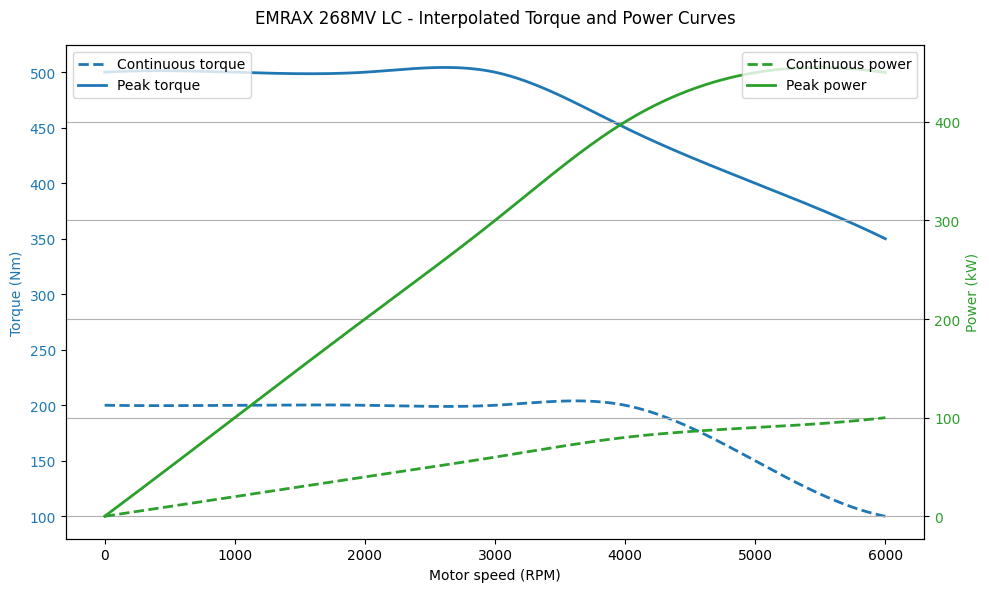

In [4]:
# @title Splitline e Comparação EMRAX268
from scipy.interpolate import interp1d

# Interpolação para suavizar os dados
rpm_interp = np.linspace(0, 6000, 1000)  # Mais pontos de RPM para suavização
torque_continuo_interp = interp1d(rpm, torque_continuo, kind='cubic')(rpm_interp)
torque_pico_interp = interp1d(rpm, torque_pico, kind='cubic')(rpm_interp)
potencia_continua_interp = interp1d(rpm, potencia_continua, kind='cubic')(rpm_interp)
potencia_pico_interp = interp1d(rpm, potencia_pico, kind='cubic')(rpm_interp)


# Replotar com interpolação
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curva de Torque interpolada
ax1.set_xlabel('Motor speed (RPM)')
ax1.set_ylabel('Torque (Nm)', color='tab:blue')
ax1.plot(rpm_interp, torque_continuo_interp, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax1.plot(rpm_interp, torque_pico_interp, label='Peak torque', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Curva de Potência interpolada
ax2 = ax1.twinx()
ax2.set_ylabel('Power (kW)', color='tab:green')
ax2.plot(rpm_interp, potencia_continua_interp, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, potencia_pico_interp, label='Peak power', color='tab:green', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adicionando título e legendas
fig.suptitle('EMRAX 268MV LC - Interpolated Torque and Power Curves')
fig.tight_layout()

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()


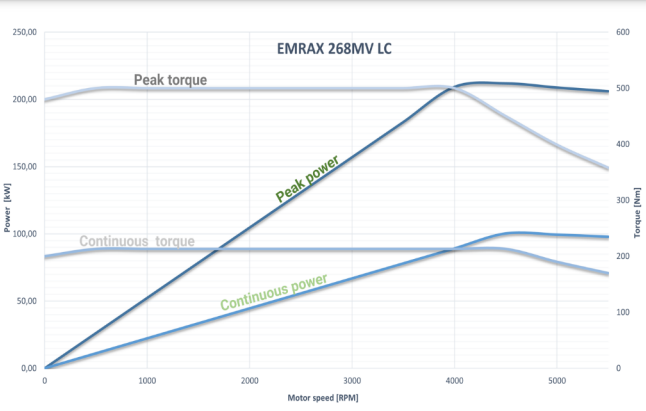

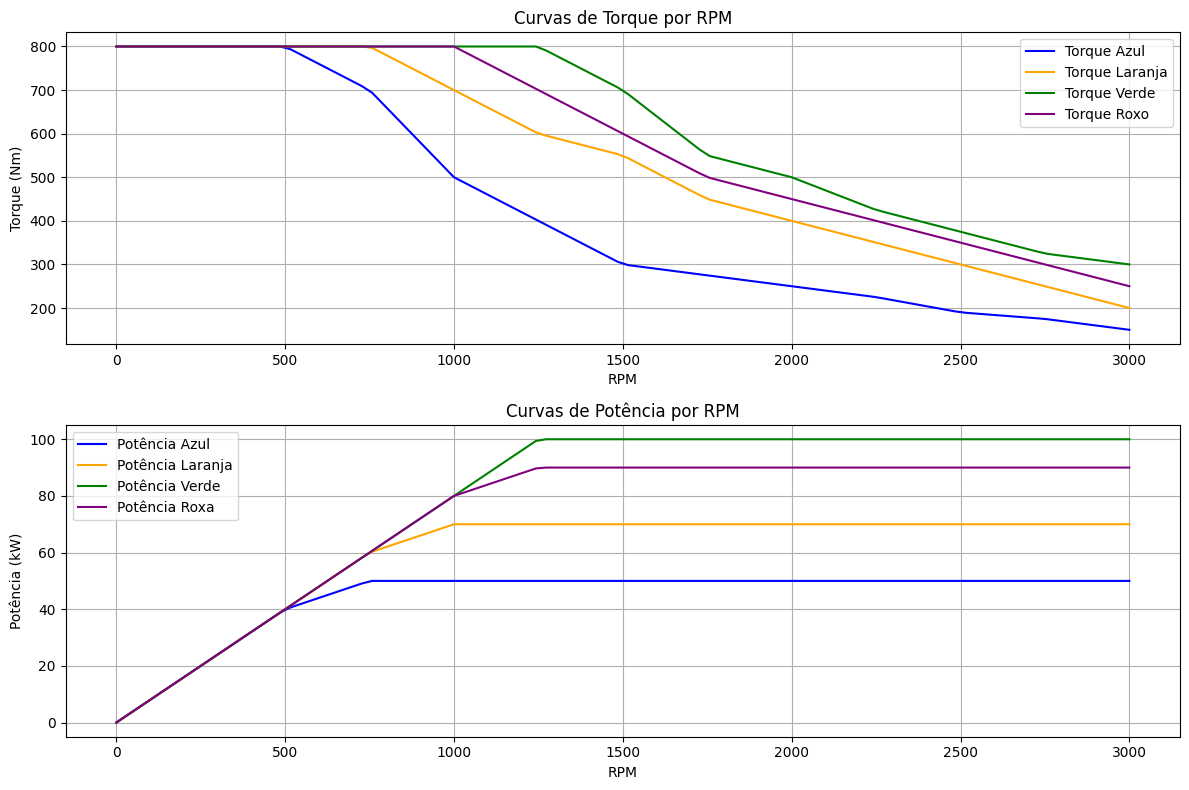

In [5]:
# @title Estimação de curva YASA
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Dados de RPM e Torque/Potência ajustados
rpm = np.array([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000])

# Definindo os torques conforme especificado
torque_azul = np.array([800, 800, 800, 700, 500, 400, 300, 275, 250, 225, 190, 175, 150])
torque_laranja = np.array([800, 800, 800, 800, 700, 600, 550, 450, 400, 350, 300, 250, 200])
torque_verde = np.array([800, 800, 800, 800, 800, 800, 700, 550, 500, 425, 375, 325, 300])
torque_roxo = np.array([800, 800, 800, 800, 800, 700, 600, 500, 450, 400, 350, 300, 250])

# Ajustando as potências conforme a faixa de torque constante
potencia_azul = np.array([0, 20, 40, 50,50, 50, 50, 50, 50, 50, 50, 50, 50])
potencia_laranja = np.array([0, 20, 40, 60, 70, 70, 70, 70, 70, 70, 70, 70, 70])
potencia_verde = np.array([0, 20, 40, 60, 80, 100, 100, 100, 100, 100, 100, 100, 100])
potencia_roxa = np.array([0, 20, 40, 60, 80, 90, 90, 90, 90, 90, 90, 90, 90])

# Interpolação para RPM mais refinado
rpm_fino = np.linspace(0, 3000, 100)  # 100 pontos de 0 a 3000 RPM

# Interpolando os dados de torque
interp_torque_azul = interp1d(rpm, torque_azul, kind='linear')(rpm_fino)
interp_torque_laranja = interp1d(rpm, torque_laranja, kind='linear')(rpm_fino)
interp_torque_verde = interp1d(rpm, torque_verde, kind='linear')(rpm_fino)
interp_torque_roxo = interp1d(rpm, torque_roxo, kind='linear')(rpm_fino)

# Interpolando os dados de potência
interp_potencia_azul = interp1d(rpm, potencia_azul, kind='linear')(rpm_fino)
interp_potencia_laranja = interp1d(rpm, potencia_laranja, kind='linear')(rpm_fino)
interp_potencia_verde = interp1d(rpm, potencia_verde, kind='linear')(rpm_fino)
interp_potencia_roxa = interp1d(rpm, potencia_roxa, kind='linear')(rpm_fino)

# Plotando os resultados
plt.figure(figsize=(12, 8))

# Torque
plt.subplot(2, 1, 1)
plt.plot(rpm_fino, interp_torque_azul, label='Torque Azul', color='blue')
plt.plot(rpm_fino, interp_torque_laranja, label='Torque Laranja', color='orange')
plt.plot(rpm_fino, interp_torque_verde, label='Torque Verde', color='green')
plt.plot(rpm_fino, interp_torque_roxo, label='Torque Roxo', color='purple')
plt.title('Curvas de Torque por RPM')
plt.xlabel('RPM')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid()

# Potência
plt.subplot(2, 1, 2)
plt.plot(rpm_fino, interp_potencia_azul, label='Potência Azul', color='blue')
plt.plot(rpm_fino, interp_potencia_laranja, label='Potência Laranja', color='orange')
plt.plot(rpm_fino, interp_potencia_verde, label='Potência Verde', color='green')
plt.plot(rpm_fino, interp_potencia_roxa, label='Potência Roxa', color='purple')
plt.title('Curvas de Potência por RPM')
plt.xlabel('RPM')
plt.ylabel('Potência (kW)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


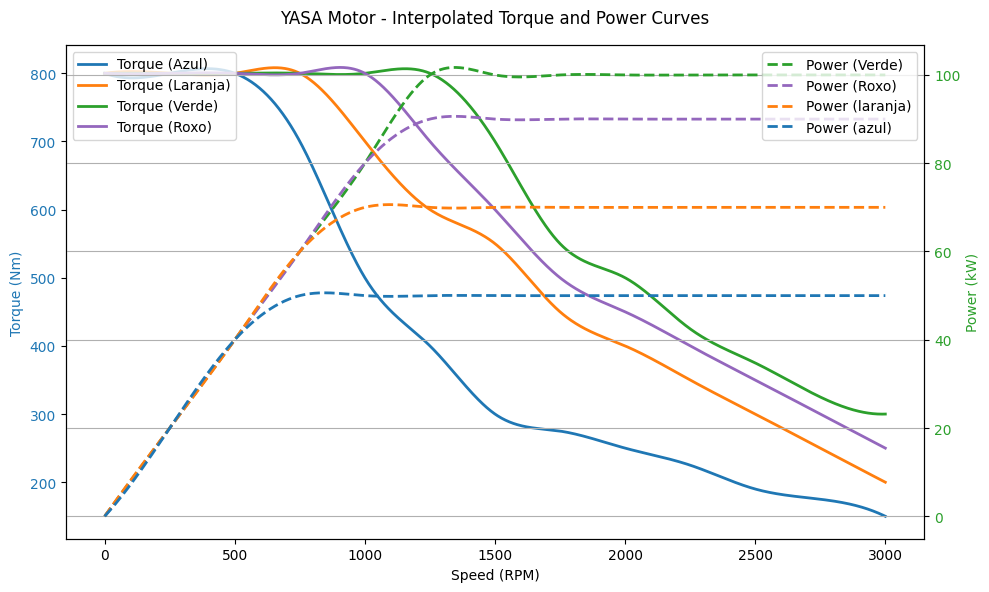

In [6]:
# @title Splitline e Comparação YASA
from scipy.interpolate import interp1d

# Interpolação dos dados
rpm_interp = np.linspace(0, 3000, 1000)  # Mais pontos para suavização
torque_azul_interp = interp1d(rpm, torque_azul, kind='cubic')(rpm_interp)
torque_laranja_interp = interp1d(rpm, torque_laranja, kind='cubic')(rpm_interp)
torque_verde_interp = interp1d(rpm, torque_verde, kind='cubic')(rpm_interp)
torque_roxo_interp = interp1d(rpm, torque_roxo, kind='cubic')(rpm_interp)
potencia_verde_interp = interp1d(rpm, potencia_verde, kind='cubic')(rpm_interp)
potencia_roxa_interp = interp1d(rpm, potencia_roxa, kind='cubic')(rpm_interp)
potencia_laranja_interp = interp1d(rpm, potencia_laranja, kind='cubic')(rpm_interp)
potencia_azul_interp = interp1d(rpm, potencia_azul, kind='cubic')(rpm_interp)

# Replotando com curvas interpoladas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curva de Torque interpolada
ax1.set_xlabel('Speed (RPM)')
ax1.set_ylabel('Torque (Nm)', color='tab:blue')
ax1.plot(rpm_interp, torque_azul_interp, label='Torque (Azul)', color='tab:blue', linestyle='-', linewidth=2)
ax1.plot(rpm_interp, torque_laranja_interp, label='Torque (Laranja)', color='tab:orange', linestyle='-', linewidth=2)
ax1.plot(rpm_interp, torque_verde_interp, label='Torque (Verde)', color='tab:green', linestyle='-', linewidth=2)
ax1.plot(rpm_interp, torque_roxo_interp, label='Torque (Roxo)', color='tab:purple', linestyle='-', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Curva de Potência interpolada
ax2 = ax1.twinx()
ax2.set_ylabel('Power (kW)', color='tab:green')
ax2.plot(rpm_interp, potencia_verde_interp, label='Power (Verde)', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, potencia_roxa_interp, label='Power (Roxo)', color='tab:purple', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, potencia_laranja_interp, label='Power (laranja)', color='tab:orange', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, potencia_azul_interp, label='Power (azul)', color='tab:blue', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adicionando título e legendas
fig.suptitle('YASA Motor - Interpolated Torque and Power Curves')
fig.tight_layout()

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()


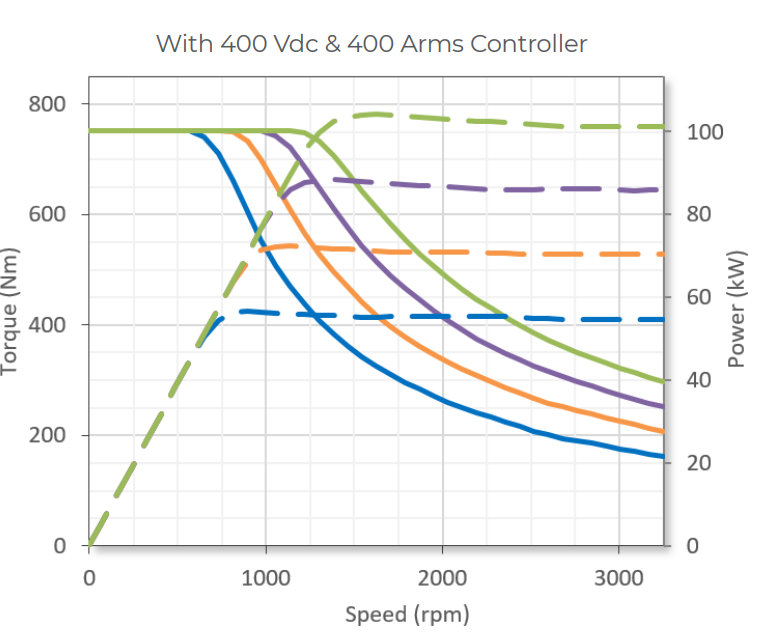

Parâmetros otimizados: [1.04811368e+00 1.00000000e-02 5.15359532e-01 1.00000000e-02
 3.00000000e+02]


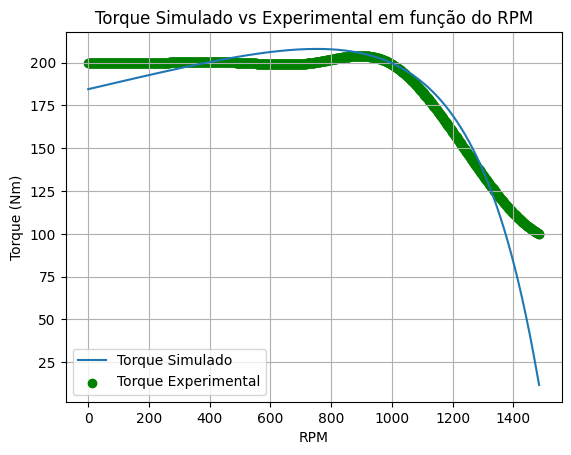

In [12]:
# @title Identificação e análise de parâmetros
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.N_s = 120 * self.frequencia / self.P  # Velocidade síncrona em RPM

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1

    def calcular_torque(self, V_fase, s):
        E2 = self.calcular_tensao_induzida(V_fase, s)
        I2 = self.calcular_corrente_de_armadura(V_fase, s)
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / (2 * np.pi * self.N_s / 60)  # Convertendo velocidade síncrona de RPM para rad/s
        return self.K * torque

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_armadura(self, V_fase, s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_erro(self, params, V_fase, s, torque_experimental):
        self.R1, self.X1, self.R2, self.X2, self.Xm = params
        torque_simulado = self.calcular_torque(V_fase, s)
        erro_total = np.sum((torque_simulado - torque_experimental) ** 2)
        return erro_total

# Função de erro total
def total_error(params, motor, V_fase, escorregamento, torque_experimental):
    return motor.calcular_erro(params, V_fase, escorregamento, torque_experimental)

# Dados experimentais de torque para escorregamento
escorregamentos = np.linspace(0.01, 1, 1000)  # Escorregamentos simulados
torques_experimentais = torque_continuo_interp  # Dados de torque (substitua pelos dados reais)

torques_experimentais_invertidos = torques_experimentais[::-1]

# Instanciando o motor com valores iniciais
motor = MotorDeGaiola(frequencia=50, P=4, R1=0.1, X1=0.2, R2=0.1, X2=0.2, Xm=5, K=0.95)

# Parâmetros a serem otimizados: [R1, X1, R2, X2, Xm]
parametros_iniciais = [0.1, 0.2, 0.1, 0.2, 5]
param_bounds = [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 10), (0.1, 300)]

# Função de otimização
result = opt.minimize(total_error, parametros_iniciais, args=(motor, 220, escorregamentos, torques_experimentais_invertidos), bounds=param_bounds)

# Imprimindo parâmetros otimizados
parametros_otimizados = result.x
print(f"Parâmetros otimizados: {parametros_otimizados}")

# Comparando torque simulado com experimental
torques_simulados = [motor.calcular_torque(220, s) for s in escorregamentos]

# Convertendo escorregamento para RPM
rpm_simulados = motor.N_s * (1 - escorregamentos)

plt.plot(rpm_simulados, torques_simulados, label='Torque Simulado')
#plt.scatter(rpm_simulados, torques_experimentais, color='red', label='Torque Experimental')
plt.scatter(rpm_simulados, torques_experimentais_invertidos, color='green', label='Torque Experimental')
plt.xlabel('RPM')
plt.ylabel('Torque (Nm)')
plt.title('Torque Simulado vs Experimental em função do RPM')
plt.legend()
plt.grid(True)
plt.show()
